In [45]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.model_selection import train_test_split

datetime_features = ['dayofweek', 'month', 'hour', 'minute', 'is_weekend']

def get_masked_data(df: pd.DataFrame):
    start_timestamp = pd.to_datetime('2023-01-01 01:00:00')
    end_timestamp = pd.to_datetime('2023-12-31 23:00:00')

    # Create a boolean mask for the specified time range
    mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    df = df[mask]
    df.fillna(0, inplace=True)
def to_input(df: pd.DataFrame):
    df['precipitation'].fillna(0, inplace=True)

    return df[['percentage', 'precipitation']].values

df = pd.read_parquet("../data/rucphen_precipitation_clean.parquet")
df.rename(columns={'polygon_1663': 'precipitation'}, inplace=True)
input_data = to_input(df)

X = df['precipitation']
y = df['percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Reshape the precipitation column
exog_values = X_train.values.reshape(-1, 1)

# Fit ARIMA model with exogenous variables
order = (1, 1, 1)  # Specify the order of the ARIMA model
model = SARIMAX(y_train, order=order, exog=exog_values)
result = model.fit(disp=False)

/home/stijn/miniforge3/envs/models/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/stijn/miniforge3/envs/models/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/home/stijn/miniforge3/envs/models/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


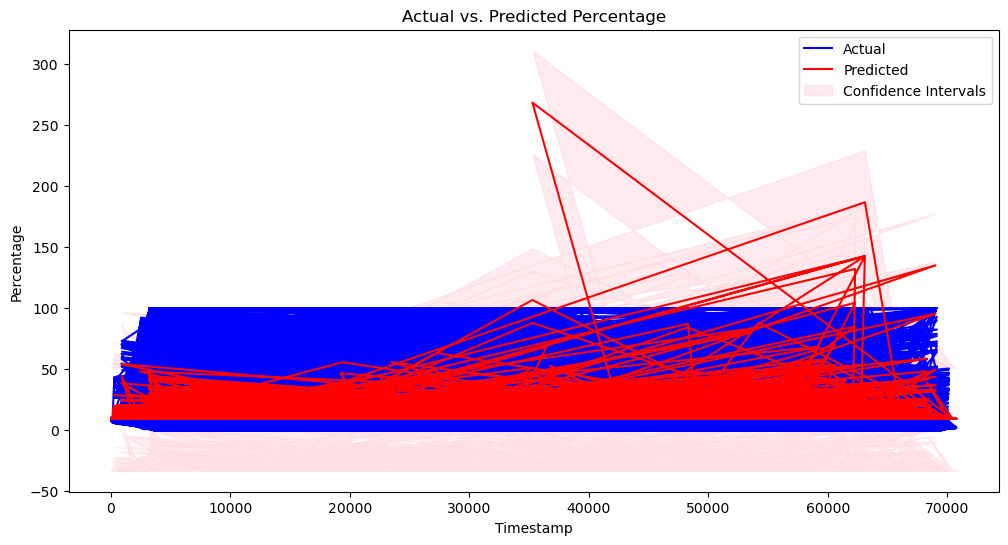

In [47]:
import matplotlib.pyplot as plt

# Get the forecast for the test set
forecast = result.get_forecast(steps=len(X_test), exog=X_test.values.reshape(-1, 1))

# Extract the predicted values and confidence intervals
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predicted_values, label='Predicted', color='red')

# Fill the area between the confidence intervals
plt.fill_between(y_test.index, confidence_intervals['lower percentage'], confidence_intervals['upper percentage'], color='pink', alpha=0.3, label='Confidence Intervals')

plt.title('Actual vs. Predicted Percentage')
plt.xlabel('Timestamp')
plt.ylabel('Percentage')
plt.legend()
plt.show()

/home/stijn/miniforge3/envs/models/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/stijn/miniforge3/envs/models/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


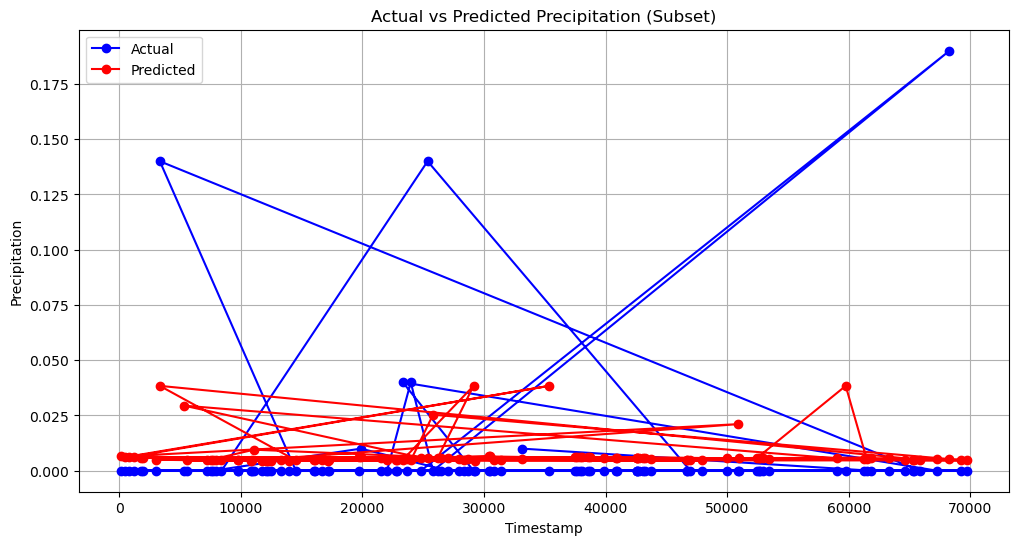

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Make predictions for the first three data points
start_prediction = 2000
end_prediction = 4000
predictions = result.get_prediction(start=start_prediction, end=end_prediction, exog=X_test)
predicted_values = predictions.predicted_mean

# Visualize the results for the subset
plt.figure(figsize=(10, 6))
plt.plot(X_test.index[start_prediction:end_prediction + 1], X_test['percentage'].iloc[start_prediction:end_prediction + 1],
         label='Actual')
plt.plot(X_test.index[start_prediction:end_prediction + 1], predicted_values,
         label='Predicted', linestyle='dashed')
plt.title('Actual vs Predicted Percentage (Subset)')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.legend()
plt.show()
# Calculate accuracy
mae = mean_absolute_error(X_test['percentage'], predicted_values)
print(f'Mean Absolute Error (MAE): {mae}')

In [ ]:
result.plot_diagnostics(figsize=(12, 8))
plt.show()